In [1]:
import warnings
from helper import *
from pprint import pprint
import tensorflow as tf
from math import ceil

# disable tensorflow warnings
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [2]:
# basic configuration
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
pd.set_option('display.max_columns', 500)

In [3]:
# get the data files and their paths
file_dict, file_dir, master_dir = get_data_files()

In [4]:
# initialize the master dataframe to store all the data
master_df = pd.DataFrame()

In [5]:
# # get the file indexes
available_file_indexes = get_file_indexes(file_dict=file_dict)

In [6]:
# get file names for the given year(s)
file_dict_given_years = create_file_dict(file_dict=file_dict, years=[2022, 2023])

In [7]:
# find top 20 pipes for every file
for year, files in file_dict_given_years.items():
    access_index = 0
    for index in available_file_indexes[year]:
        master_df = find_common_pipes(file_index=access_index, file_year=year, 
                                      top_level_df=master_df, file_dict=file_dict, 
                                      master_dir=master_dir, threshold=50)
        access_index += 1

In [8]:
# create dataframe contains pipe production data for every week and write them to Excel files
exp_df, exp_df_th = create_transposed_and_unique_df(master_df=master_df, 
                                                    sheet_names=["General", "Experimental"], 
                                                    file_dir=file_dir)

In [9]:
# format the Excel files
format_general_sheet(file_dir=file_dir)
format_experimental_sheet(file_dir=file_dir)

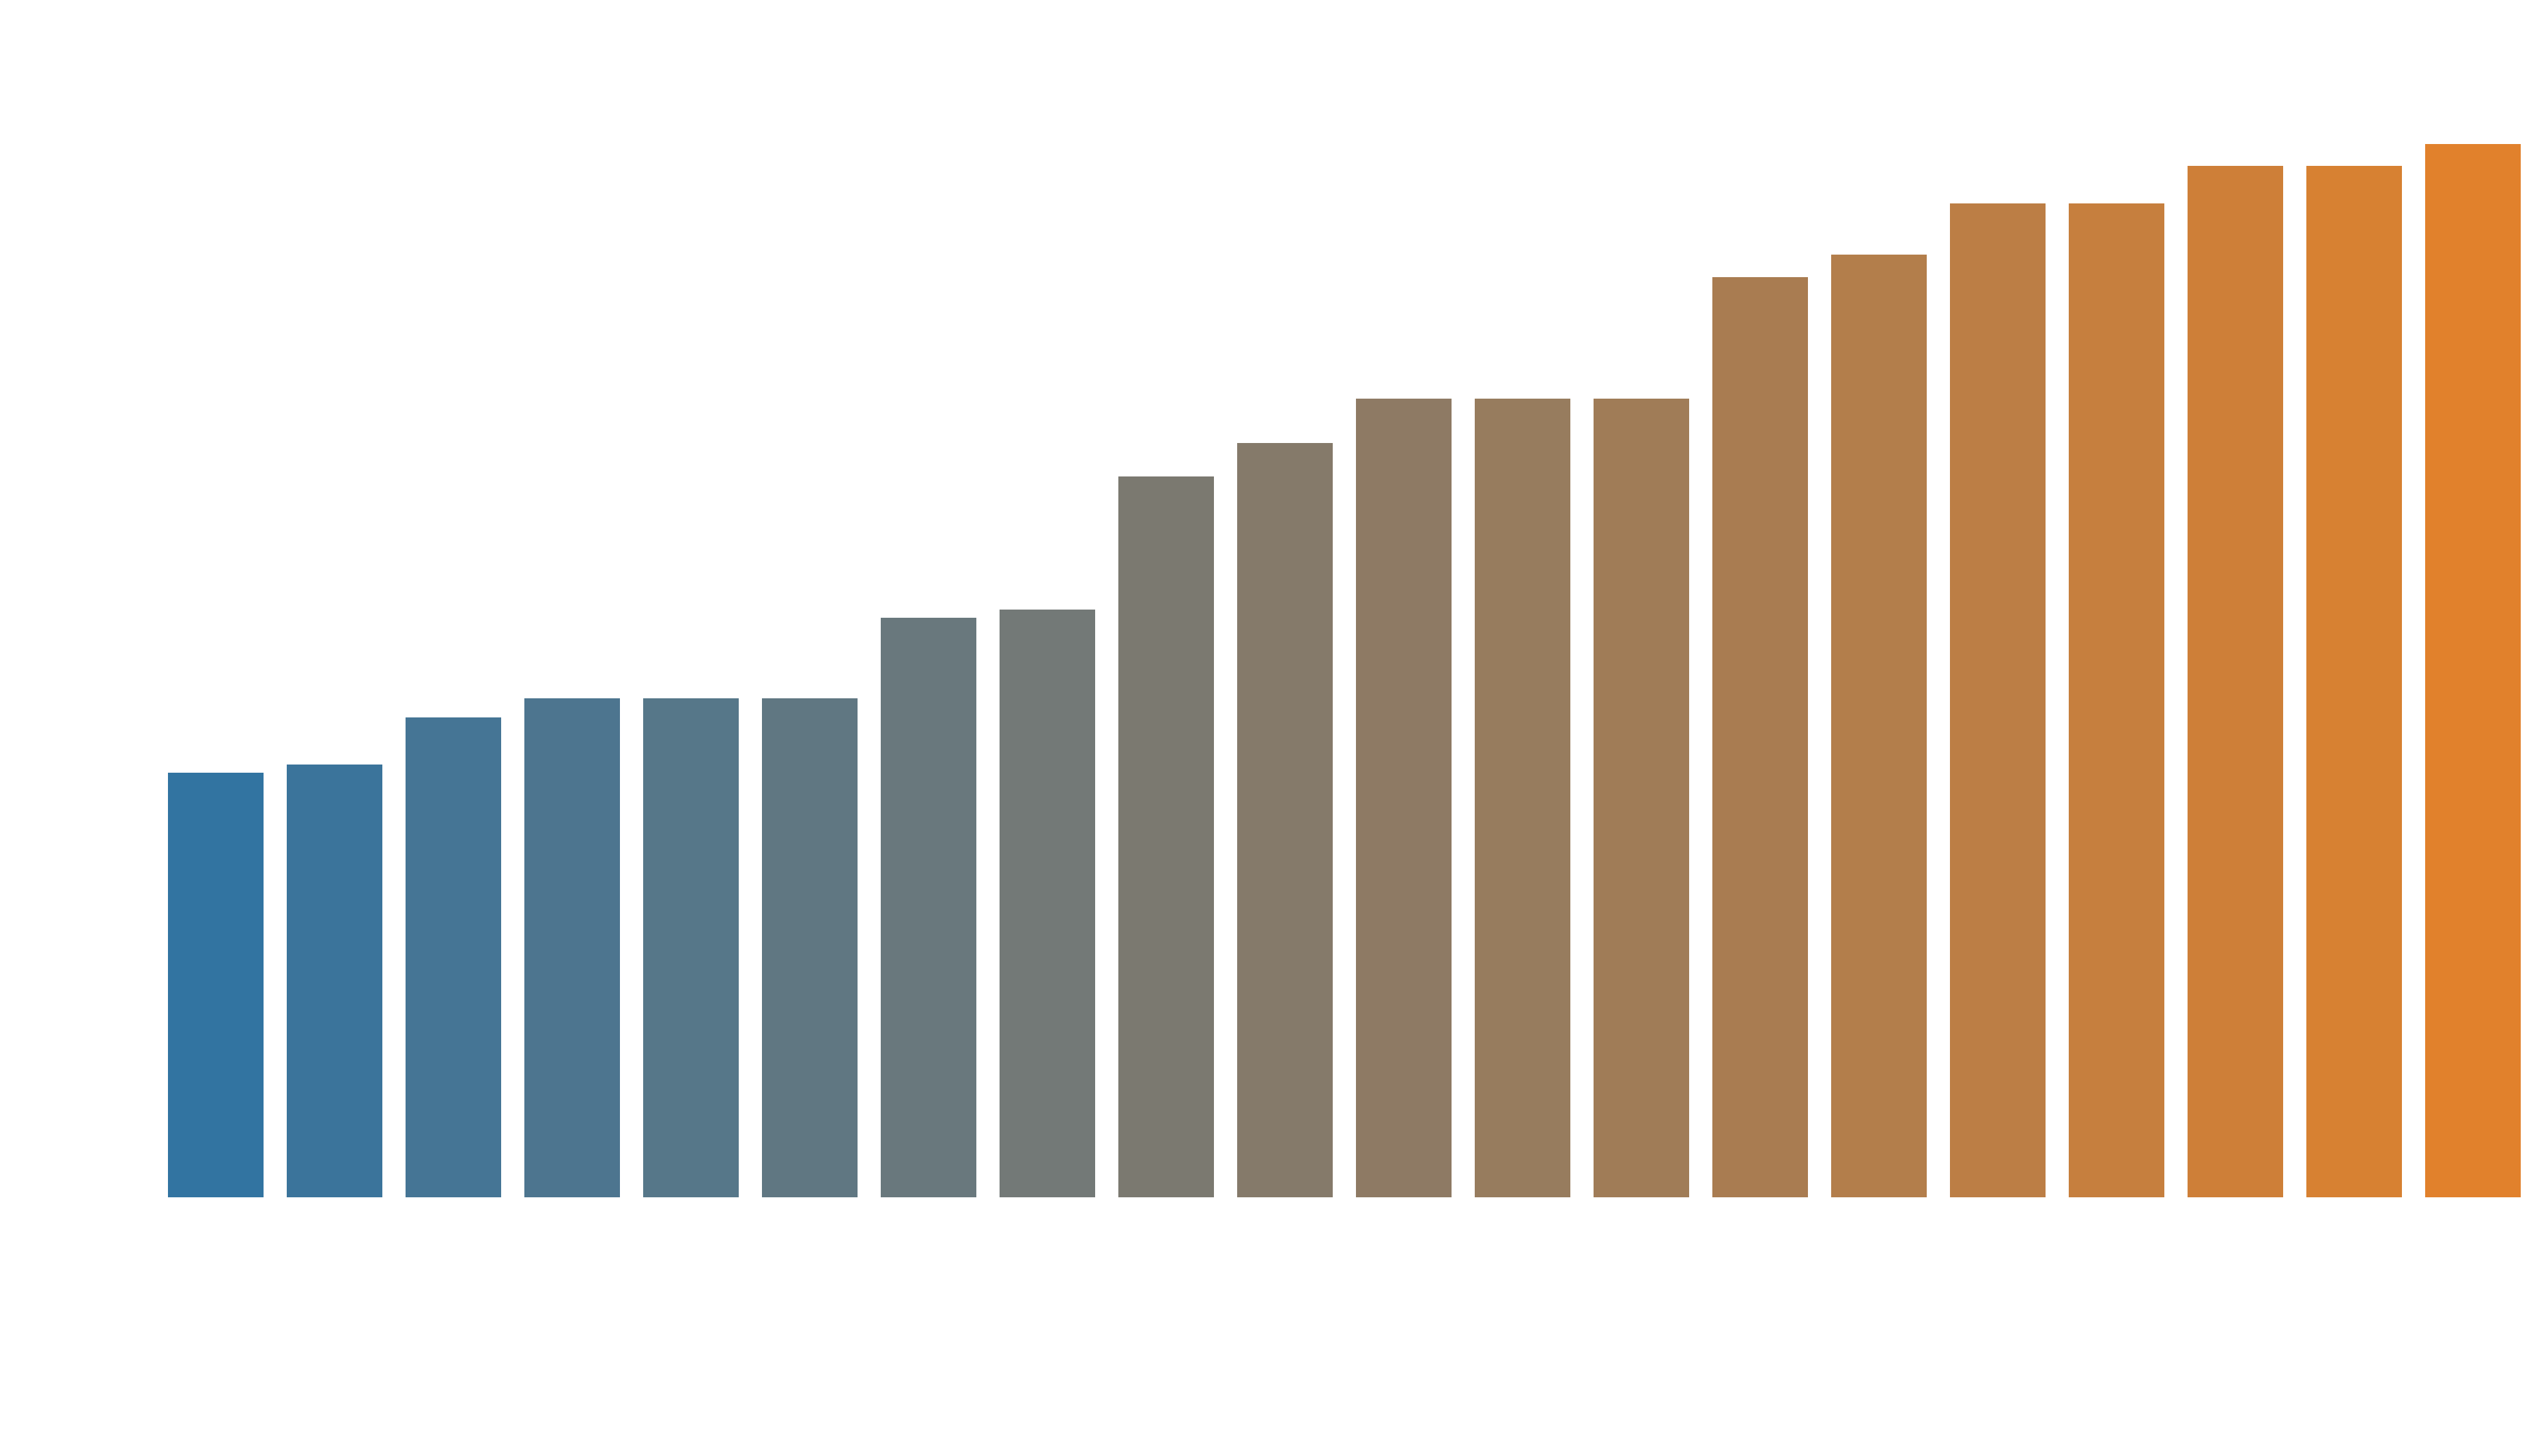

In [10]:
# plot the most popular 20 pipes for a specific week
create_bar_plot(df=exp_df_th,
                selected_year=2022,
                file_index="34",
                ascending=True,
                threshold=20)

In [11]:
# create a unique dataframe that contains all the data (2021-2023)
final_df = create_unique_df(df=exp_df)

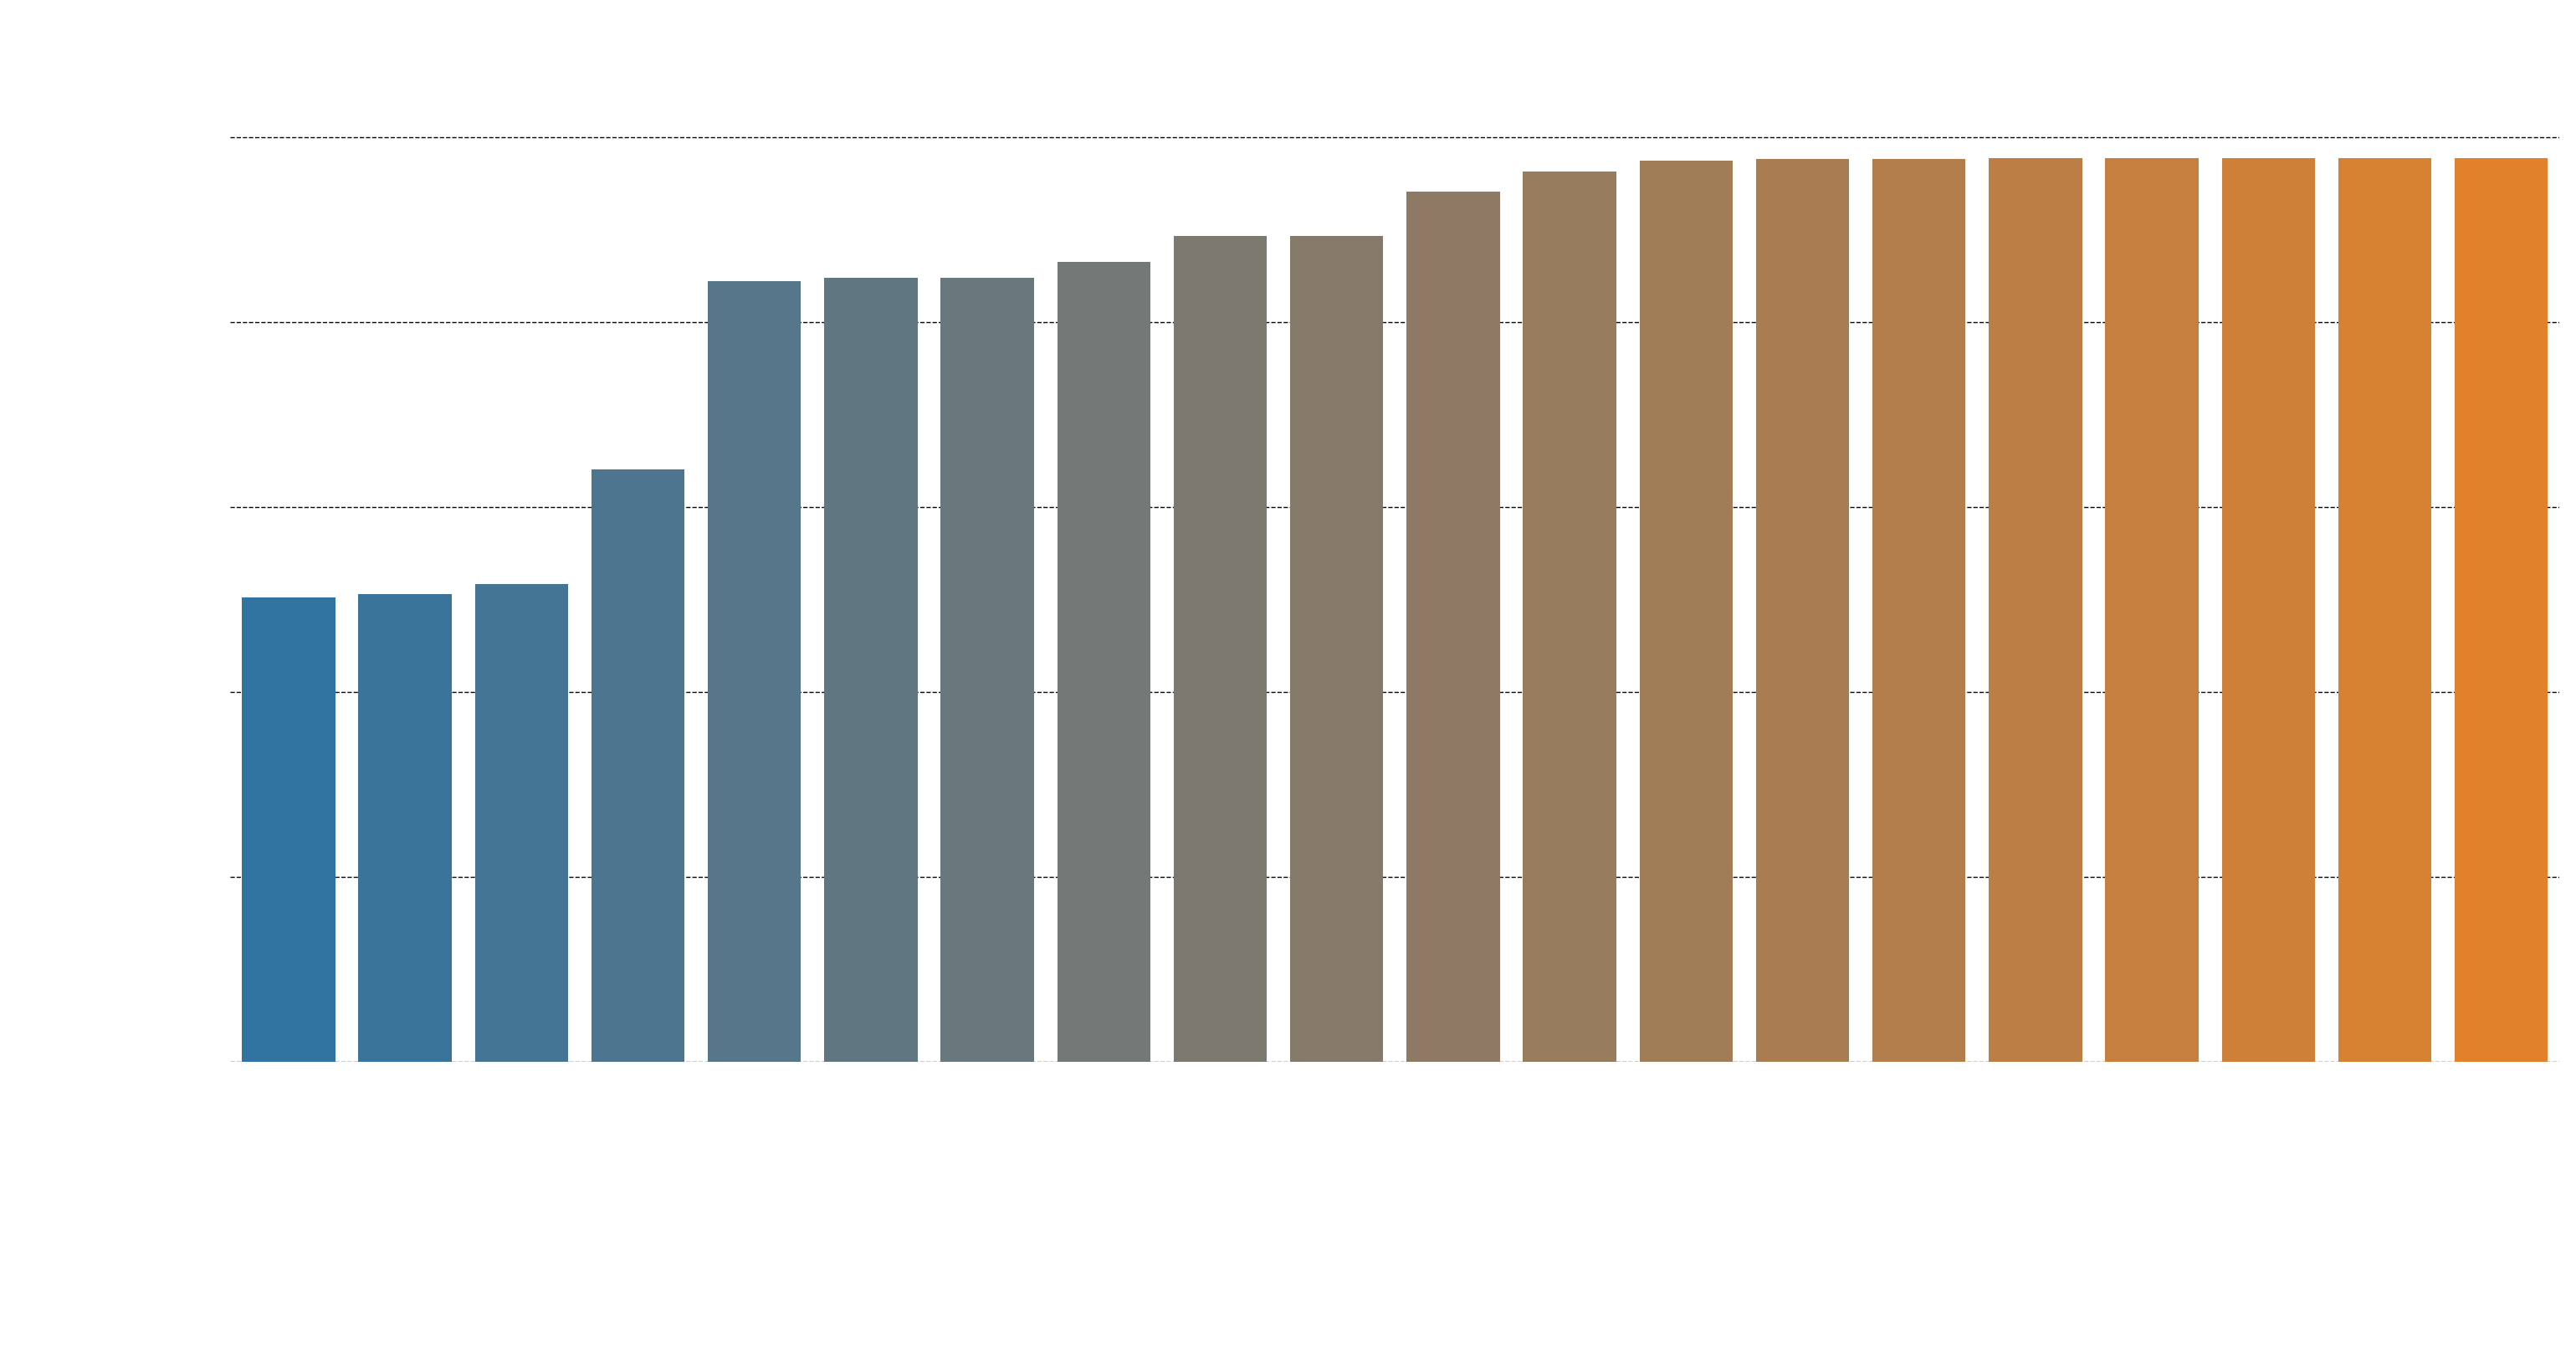

In [12]:
# plot the most popular 20 pipes for all the weeks (2021-2023)
unique_pipe_bar_plot(pipe_df=final_df,
                     total_quantity_limit=50000,
                     fig_size=(16, 7),
                     rotation='vertical',
                     ascending=True,
                     years=[2022, 2023])

In [13]:
# get the occurrences per file
pipe_occurrences_df = get_occurrences_per_file(df=exp_df)

In [14]:
# get the files with a given threshold of occurrences
pipes_in_threshold_df = get_occurrences_with_threshold(df=pipe_occurrences_df, threshold=50)

In [15]:
# filter the dataframe with the top 20 pipes
top_20_pipes = pipe_occurrences_df.iloc[:, 0].head(20)
top_20_pipes_df = list(map(int, pipe_occurrences_df[pipe_occurrences_df.iloc[:, 0].isin(top_20_pipes)].index))

In [16]:
# combine all the files satisfying the threshold for the popular pipes
all_in_one = combine_all_files_within_threshold(
    file_dict=file_dict_given_years, master_dir=master_dir, threshold_df=top_20_pipes_df)
all_in_one_T = convert_multi_to_single_df(df=all_in_one)

In [17]:
all_in_one_T = all_in_one_T.sort_index(inplace=False)

In [18]:
# reindex the all_in_one_T (start from 2022-01-06) and add 7 days for each row
filled_df = all_in_one_T.copy()
filled_df.index = pd.date_range(start='2022-01-06', periods=len(all_in_one_T), freq='7D')

# # convert the index column to datetime
filled_df.index = filled_df.index.astype('datetime64[ns]')

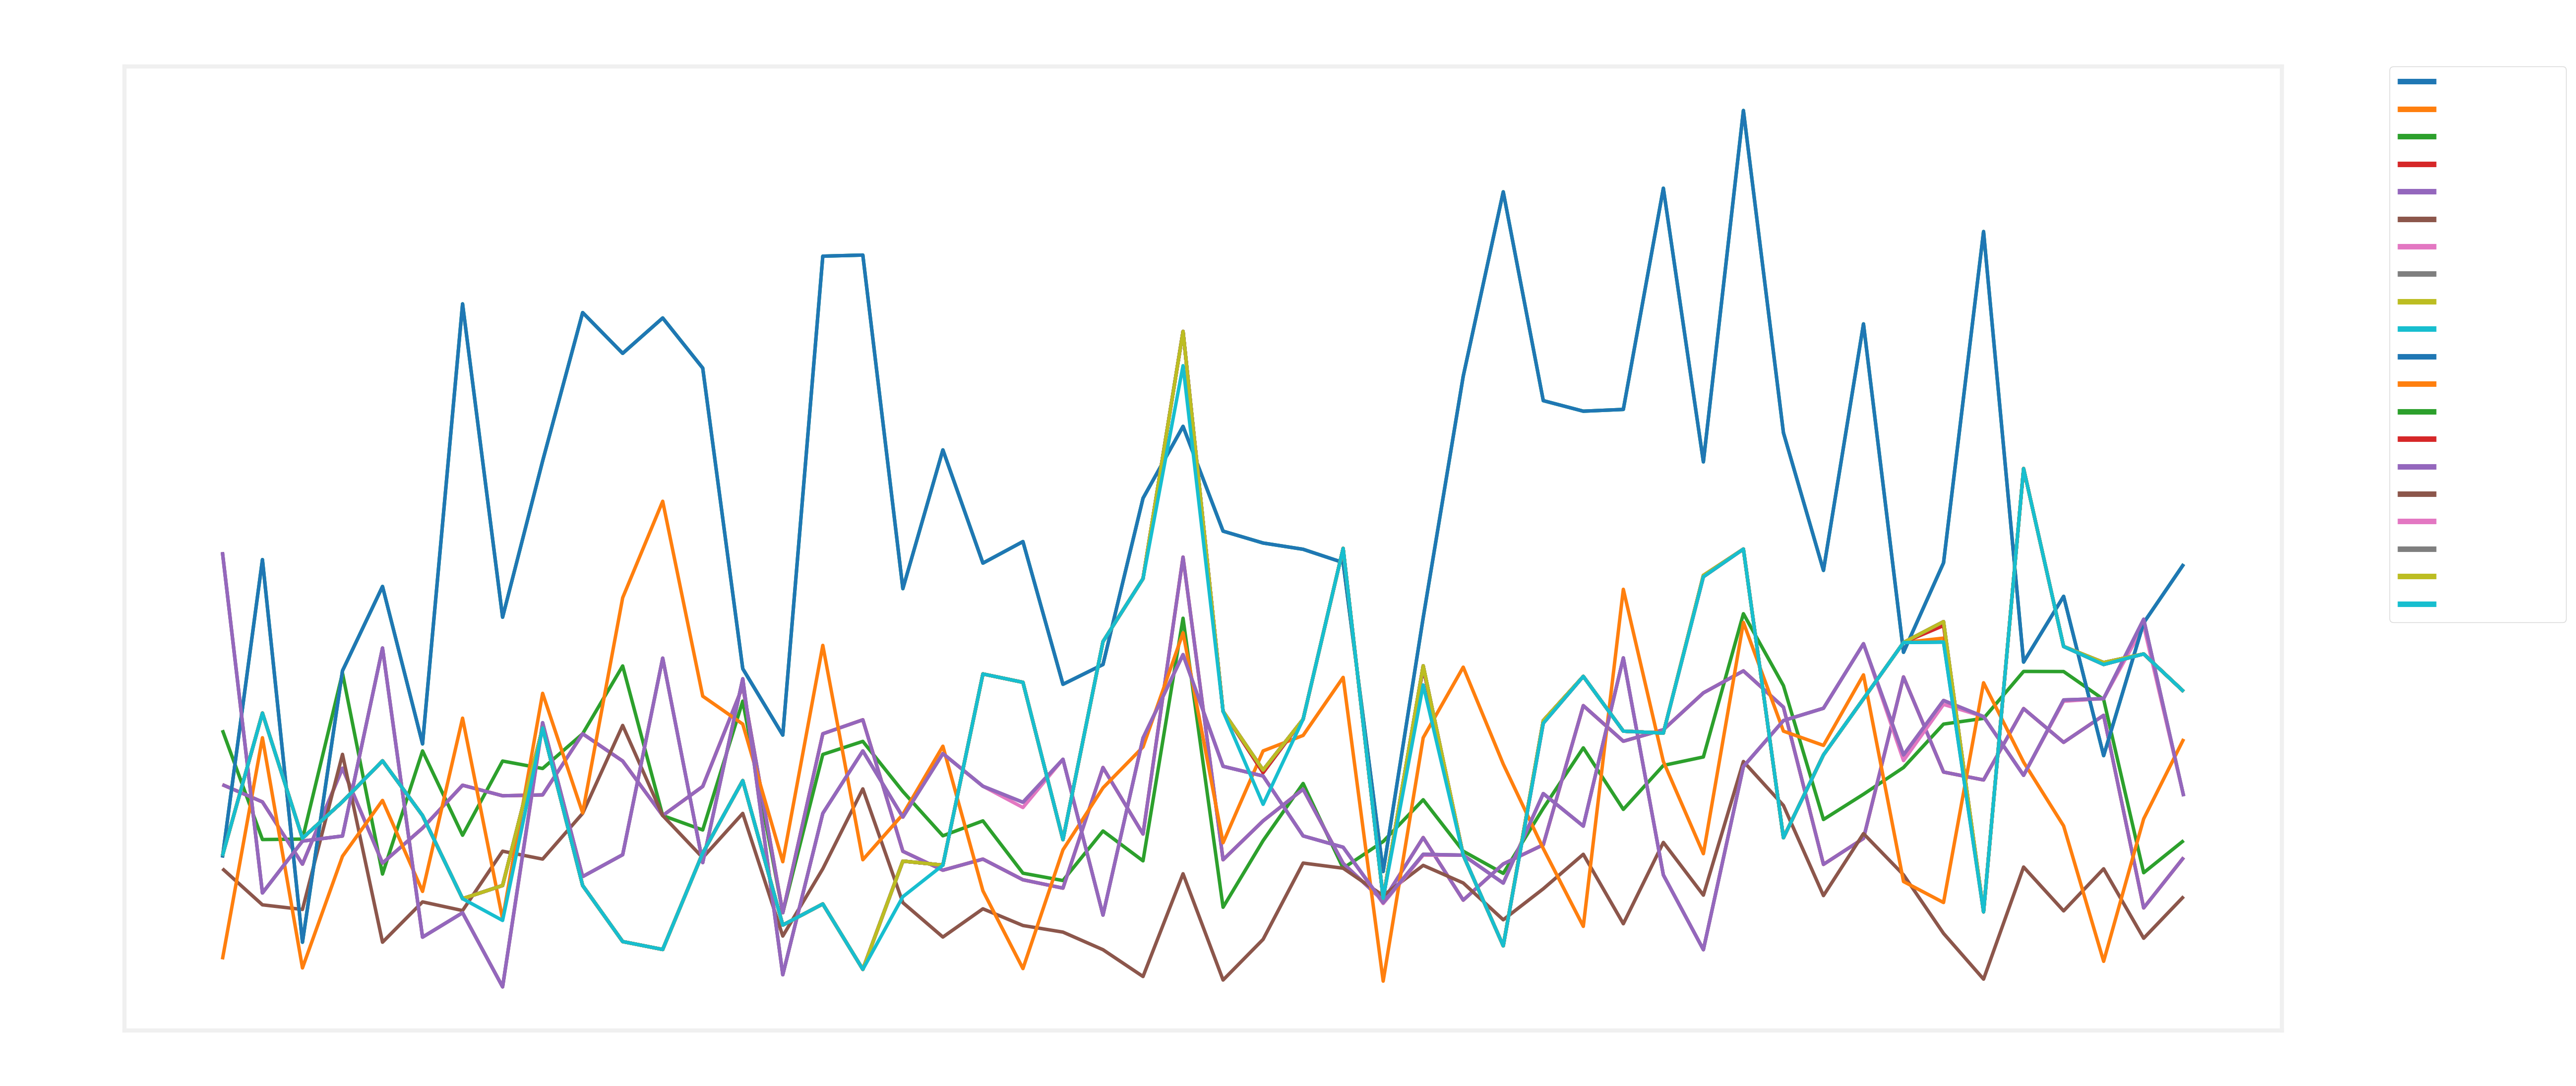

In [19]:
# plot the most popular 20 pipes throughout the given time period
configure_matplotlib(tick_major_pad=20)
fig, ax = plt.subplots(figsize=(25, 12))
sns.lineplot(data=filled_df, palette="tab10", linewidth=2.5, ax=ax, dashes=False)
plt.ylabel("Quantity")
plt.title("Top 20 Pipes in 2022-2023")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

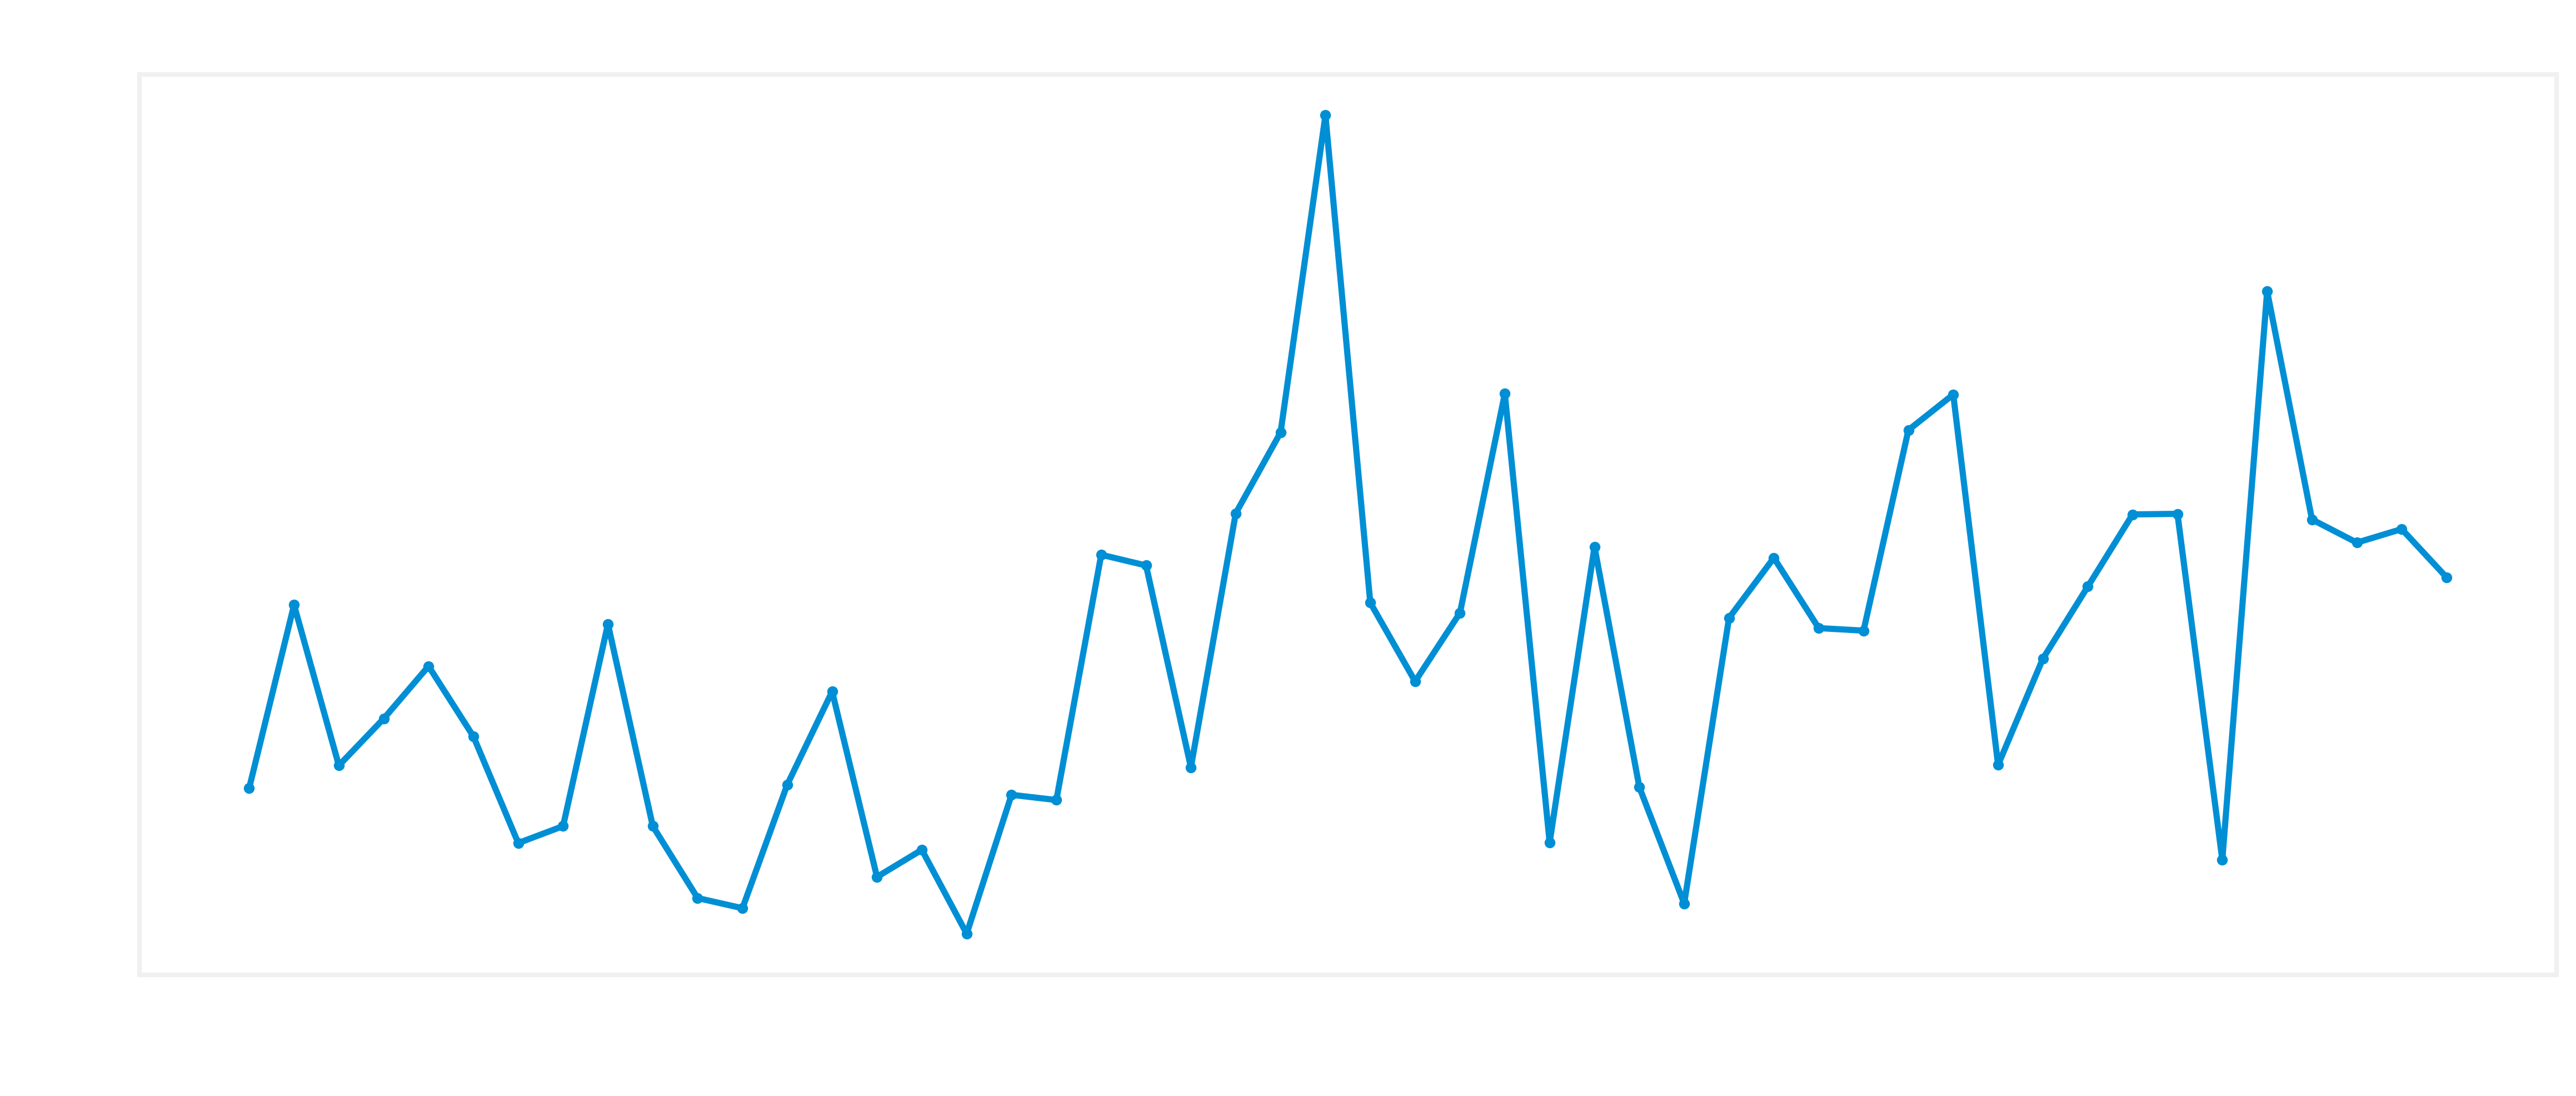

In [20]:
configure_matplotlib(tick_major_pad=20)
fig, ax = plt.subplots(figsize=(25, 10))
selected_pipe = filled_df.columns[0]
plt.plot(filled_df[selected_pipe], marker='o')
plt.xticks(rotation=90)
plt.ylabel("Quantity")
plt.title(f"Pipe TTNr: {filled_df.columns[0]}")

plt.show()

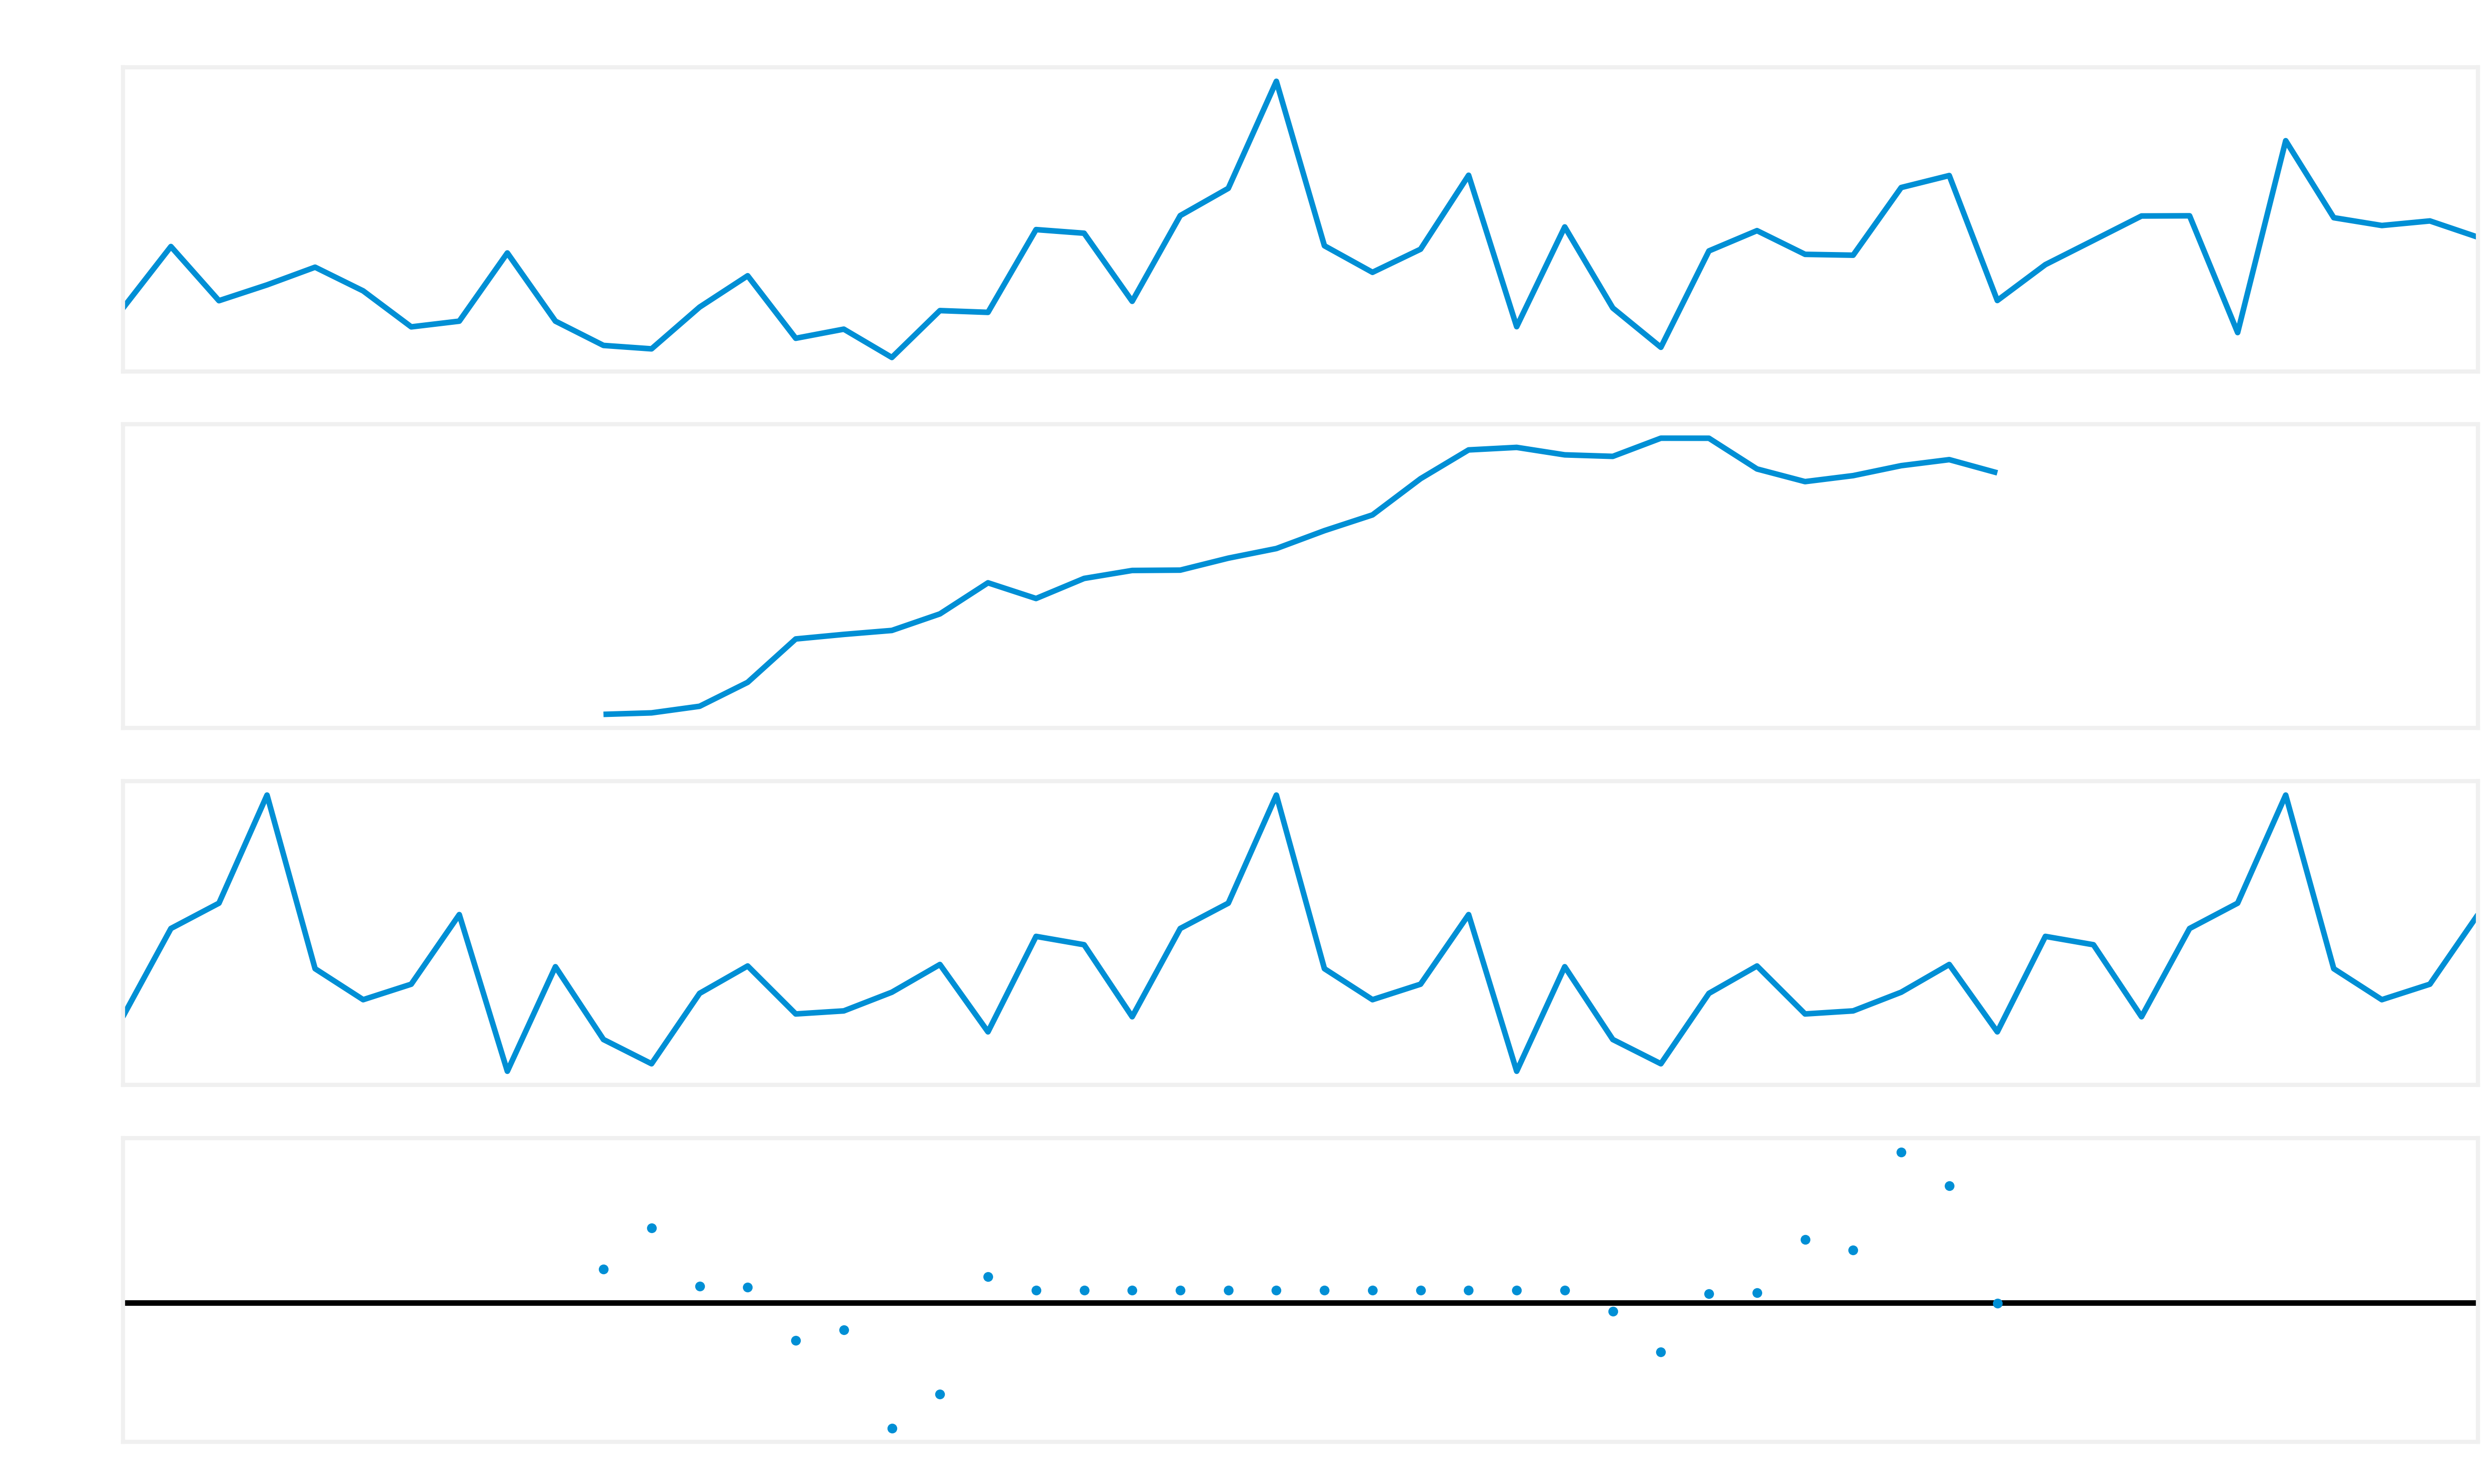

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose

# plot seasonal, trend, and residual components of the time series 
decomposition = seasonal_decompose(filled_df[selected_pipe], model='additive', period=21)

configure_matplotlib()
fig = decomposition.plot()
fig.set_size_inches(25, 15)
fig.tight_layout()
plt.show()

2023-04-25 01:11:05.308961: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-25 01:11:09.139318: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-25 01:11:10.570170: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-25 01:11:14.250238: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-25 01:11:17.071440: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-25 01:11:20.652303: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-25 01:11:23.531668: I tensorflow/core/grappler/optimizers/cust

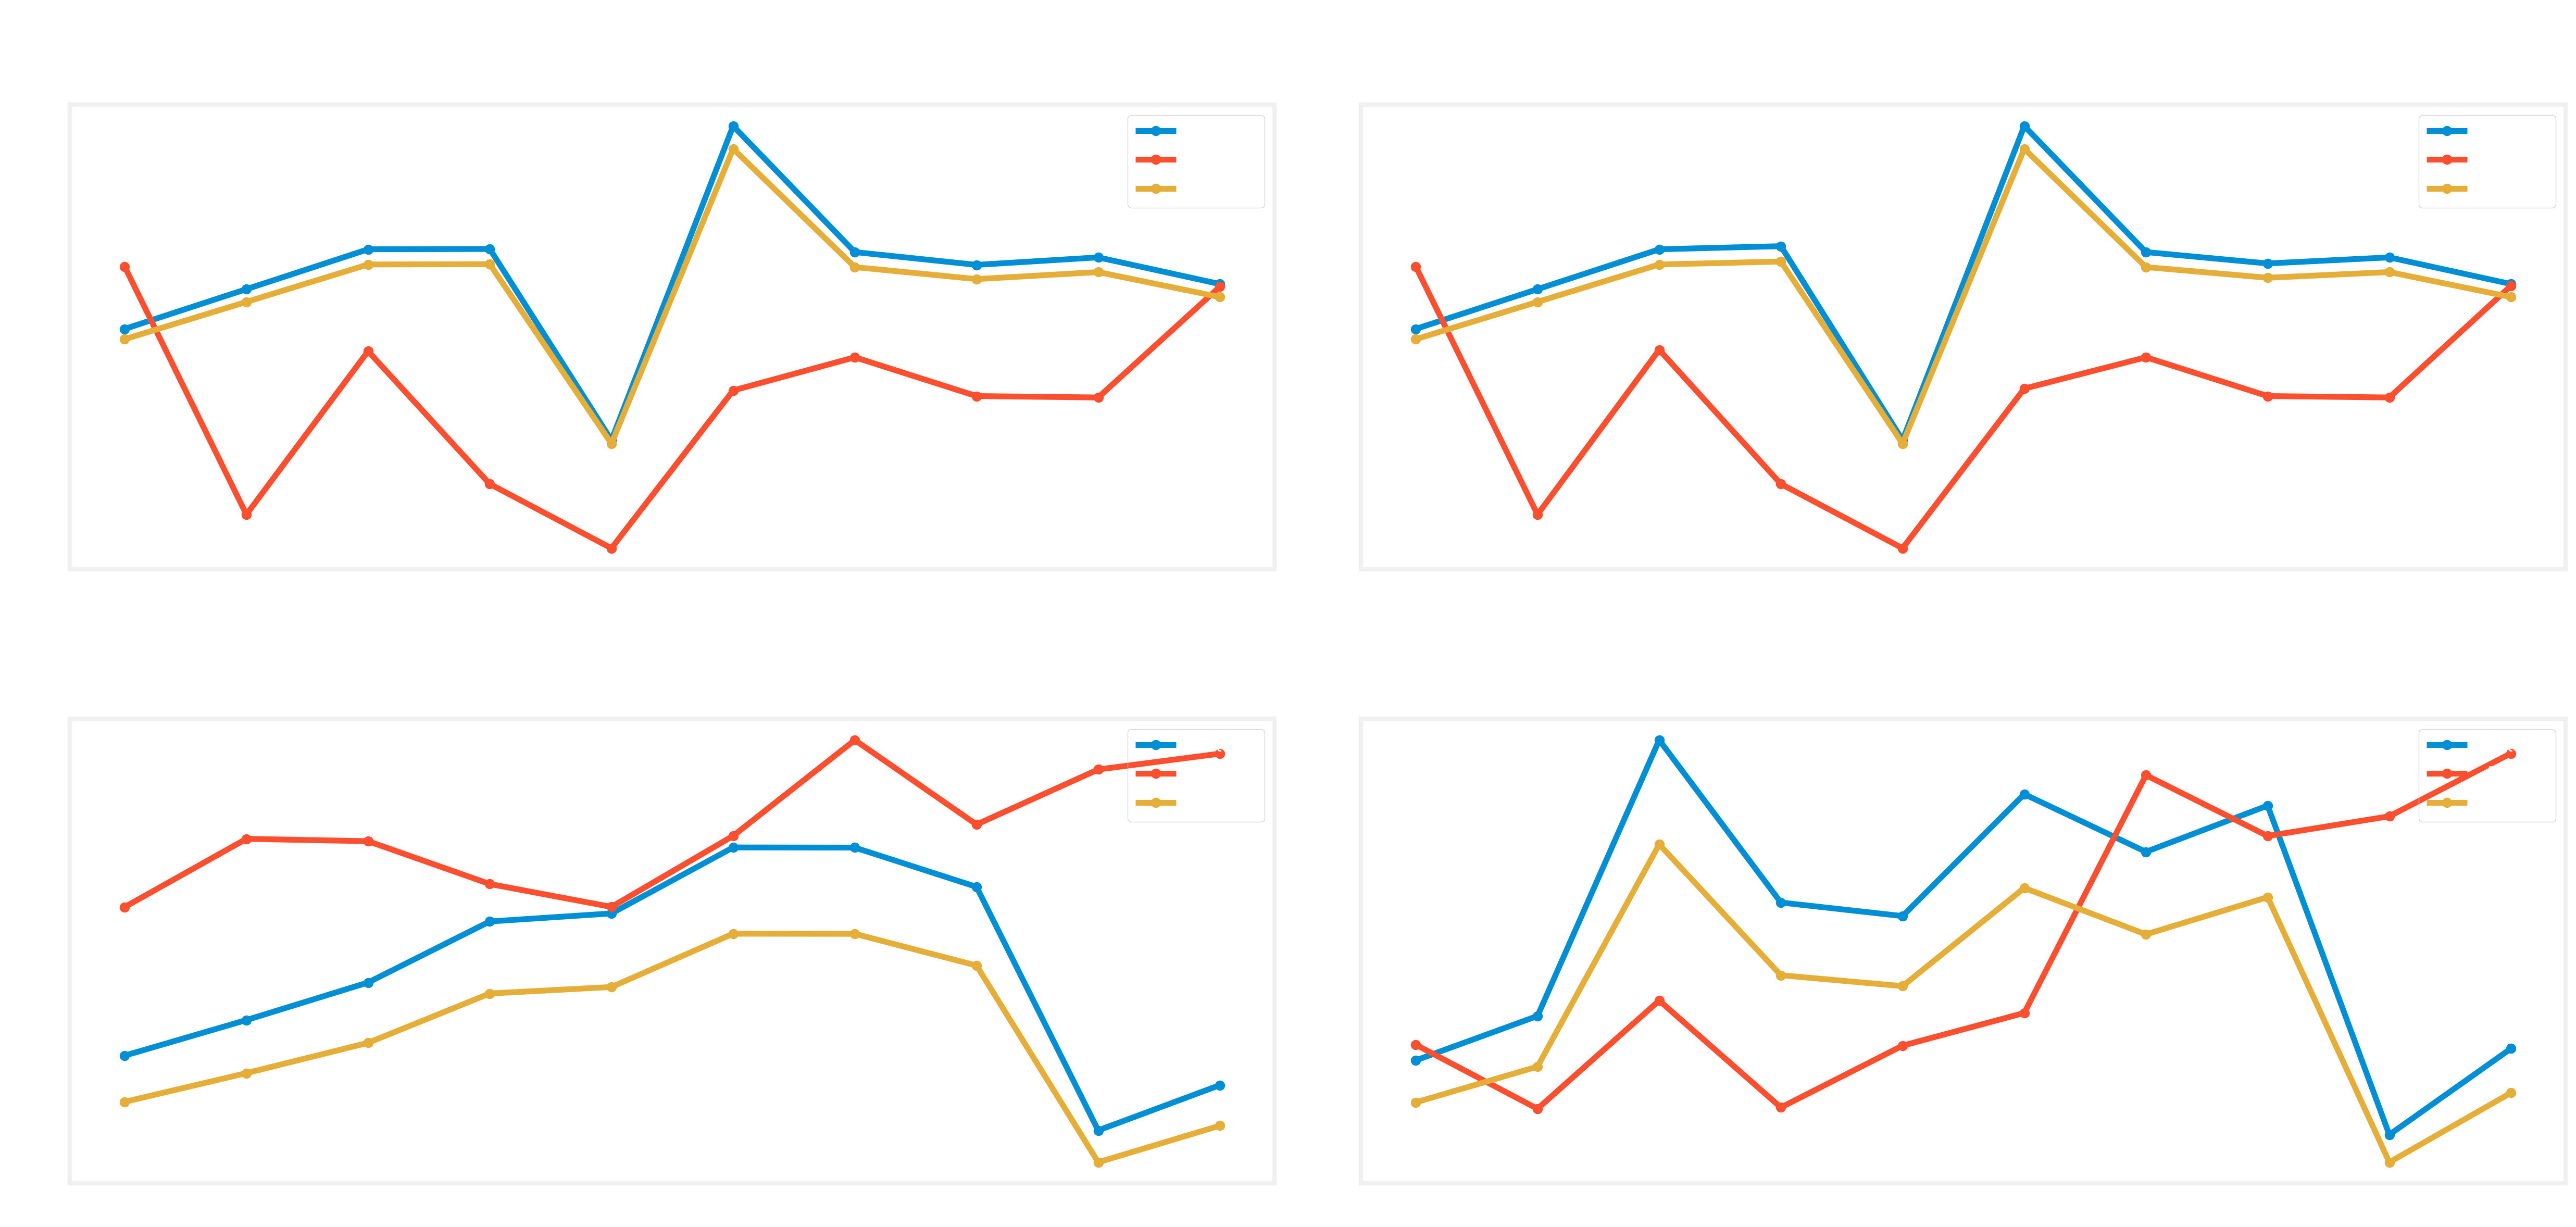

In [26]:
range_index = (0, 4)

for i in range(*range_index):
    # format the train and test data to be used in the model
    formatted_df = format_time_series_df(df=filled_df, master_df=all_in_one_T)
    pipe_number, train, test = select_pipe_and_split_data(data=formatted_df, 
                                                          pipe_index=i, 
                                                          is_sklearn=True,
                                                          test_size=0.2)
    # create and run the ARIMA model
    predictions, rmse = create_and_run_the_model(train_data=train, 
                                                 test_data=test, 
                                                 verbose=False, 
                                                 operation_type="prediction",
                                                 model_type="arima")
    
    # convert index to datetime
    test.index = test.index.strftime('%Y-%m-%d')
    predictions.index = predictions.index.strftime('%Y-%m-%d')

    # compare LSTM and ARIMA with the actual values
    ax = plt.subplot(ceil(range_index[1] / 2), 2, i+1)
    if range_index[1] - range_index[0] > 2:
        ax.figure.set_size_inches(25, 12)
    else:
        ax.figure.set_size_inches(25, 7)

    # plot ARIMA predictions
    ax.set_title(f"Pipe TTNr: {pipe_number}")
    ax.plot(test, marker='o')
    ax.plot(predictions, marker='o')

    ax.set_xticks(range(len(test.index)), test.index)

    # create and run the LSTM model
    predictions, lstm_rmse, lstm_test, train_rmse = create_lstm_model(train=train, test=test, activation='relu')

    # plot LSTM predictions
    ax.set_title(f"Pipe TTNr: {pipe_number}\n ARIMA: {rmse:.2f} - LSTM: {lstm_rmse:.2f}")
    ax.plot(predictions, marker='o')
    ax.set_xticks(range(len(test.index)), test.index)
    ax.legend(["Actual", "ARIMA", "LSTM"], loc="upper right")
    
plt.tight_layout()
plt.show()